In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl

import am_sim as ams

In [2]:
from utilities.analyze_inference import best_par_in_df

# load inferred parameter set
search_df = pd.read_csv('inference_results/t_final_search_history.csv', index_col=0)
par = best_par_in_df(search_df)

### Panel A - asymptotic evolution

In [3]:
from utilities.asymptotic_evolution import evolve_pop_at_constant_C, asymptotic_phi_and_u

C_const = 30 # Ag concentration
T_skip = 10 # pre-evolve the initial distribution for some rounds
T_save = 60 # number of evolution rounds to save to be then plotted in panel A

# simulate evolution with constant Ag concentration
results = evolve_pop_at_constant_C(C_const, par, T_skip, T_save)

# extract results
t, N, avg_eps, distr_y, distr_x= [results[lab] for lab in ['t', 'N', 'avg_eps', 'distr_y', 'distr_x']]

# evaluate asymptotic growth rate and travelling wave speed
phi, u = asymptotic_phi_and_u(C_const, par, T_max=1000)

Successful convergence to the desired precision after 975 iterations


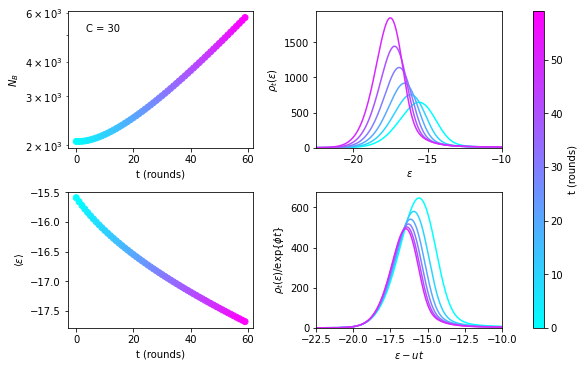

In [4]:
# plot panel A - setup figure
fig, ax = plt.subplots(2,2, figsize = (8,5), constrained_layout=True)

# setup colormap
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=t.min(), vmax=t.max())
mapp = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mapp.set_array(t)

# plot pop. size evolution
ax[0,0].scatter(t, N, color=cmap(norm(t)), zorder = 3) 

# plot pop. size evolution
ax[1,0].scatter(t, avg_eps, color=cmap(norm(t)), zorder = 3) 

# select times to be displayed
plt_idsx = range(len(t))[::10]
# for each time
for idx in plt_idsx:
    
    # evaluate population function
    pop_f = distr_y[idx] * N[idx]
    
    # plot evolution of population function
    ax[0,1].plot(distr_x, pop_f, c=cmap(norm(t[idx])))

    # evaluate rescaled population function
    shifted_x = distr_x - u * t[idx]
    rescaled_pop_f = pop_f / np.exp(phi * t[idx])
    
    # plot evolution of rescaled population function
    ax[1,1].plot(shifted_x, rescaled_pop_f, c=cmap(norm(t[idx])))

# set axes limits, scales and ticks
ax[0,0].set_yscale('log')
ax[0,1].set_ylim(bottom=0)
ax[1,1].set_ylim(bottom=0)
ax[0,1].set_xlim(-22.5, -10)
ax[1,1].set_xlim(-22.5, -10)
ax[0,1].set_xticks([-20, -15, -10])

# set labels
ax[0,0].set_xlabel('t (rounds)')
ax[0,0].set_ylabel(r'$N_B$')
ax[1,0].set_xlabel('t (rounds)')
ax[1,0].set_ylabel(r'$\langle \epsilon \rangle$')
ax[0,1].set_xlabel(r'$\epsilon$')
ax[0,1].set_ylabel(r'$\rho_t(\epsilon)$')
ax[1,1].set_xlabel(r'$\epsilon - u t$')
ax[1,1].set_ylabel(r'$\rho_t(\epsilon) / \exp \{\phi t\}$')

# write Ag concentration
ax[0,0].text(0.1, 0.85, f'C = {C_const}', transform=ax[0,0].transAxes)

# plot colorbar
plt.colorbar(mapp, ax=ax, label='t (rounds)', aspect=50.)

plt.savefig('figures/fig_4/panel_A.pdf')
plt.savefig('figures/fig_4/panel_A.svg')
plt.show()

### Panel B - pahse diagram

In [5]:
# concentration range on which to draw the phase diagram
C_range = np.logspace(0,4,20)
# maximum allowed number of iterations for the function that evaluates u and phi
T_max_sim = 10000

In [6]:
# evaluate u and phi for all specified concentrations (NB: if too long results can be loaded by executing the next cell)
phi_list = []
u_list = []
for C in C_range:
    print(C)
    phi, u = asymptotic_phi_and_u(C, par, T_max_sim)
    phi_list.append(phi)
    u_list.append(u)
    
# save results
with open('figures/fig_4/phi_u_results.pkl', 'wb') as f:
    pkl.dump([phi_list, u_list], f)
    f.close()

1.0
Successful convergence to the desired precision after 270 iterations
1.6237767391887217
Successful convergence to the desired precision after 312 iterations
2.636650898730358
Successful convergence to the desired precision after 368 iterations
4.281332398719393
Successful convergence to the desired precision after 441 iterations
6.951927961775605
Successful convergence to the desired precision after 534 iterations
11.28837891684689
Successful convergence to the desired precision after 854 iterations
18.329807108324356
Successful convergence to the desired precision after 794 iterations
29.76351441631318
Successful convergence to the desired precision after 972 iterations
48.32930238571752
Successful convergence to the desired precision after 1191 iterations
78.47599703514611
Successful convergence to the desired precision after 1464 iterations
127.42749857031335
Successful convergence to the desired precision after 1812 iterations
206.913808111479
Successful convergence to the desi

In [7]:
# load results
with open('figures/fig_4/phi_u_results.pkl', 'rb') as f:
    phi_list, u_list = pkl.load(f)
    f.close()

In [8]:
# find the two critical concentrations by interpolation
import scipy.optimize as spo
import scipy.interpolate as spi

log_C = np.log(C_range)

# find C^* with an interpolation of phi 
interp_phi = spi.interp1d(log_C, phi_list, bounds_error=True)
log_Cs = spo.brentq(interp_phi, log_C.min(), log_C.max())

# find C^** with an interpolation of u
interp_u = spi.interp1d(log_C, u_list, bounds_error=True)
log_Css = spo.brentq(interp_u, log_C.min(), log_C.max())

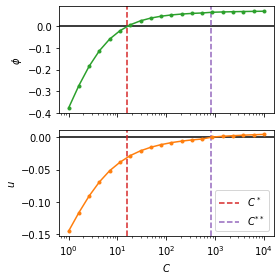

In [9]:
# plot panel B - setup figure
fig, ax = plt.subplots(2,1, sharex=True, figsize=(4,4))

for ax_i in ax:
    # for both axes draw an horizontal line on zero
    ax_i.axhline(0, c='k')
    # and draw two vertical axes at the critical concentrations
    ax_i.axvline(np.exp(log_Cs), c='C3', ls='--',label=r'$C^*$')
    ax_i.axvline(np.exp(log_Css), c='C4', ls='--', label=r'$C^{**}$')

# plot phi and u
ax[0].plot(C_range, phi_list, 'C2.-')
ax[1].plot(C_range, u_list, 'C1.-')

# labels
ax[0].set_ylabel(r'$\phi$')
ax[1].set_ylabel(r'$u$')
ax[1].set_xlabel(r'$C$')
ax[1].legend()

# set logarithmic scale on concentration
plt.xscale('log')

plt.tight_layout()
plt.savefig('figures/fig_4/panel_B.pdf')
plt.savefig('figures/fig_4/panel_B.svg')
plt.show()